## Table of contents:
* [Set env](#set_env)
* [General information on Reactome biopax file](#general_reactome)
    * [Query 1: Number of elements for each biopax types](#query1)
* [Complexes](#complexes)
    * [Complexes in BioPAX specifications](#complexes_in_biopax)
    * [Complexes in Reactome](#complex_reactome)
        * [Summary](#summary)
        * [Query 2: How many black-box complexes?](#query2) 
        * [Query 3: How many complexes have at least one component? ](#query3)
        * [Query 4: How many complexes have at least one component that is a complex? ](#query4)
        * [Query 5: How many complexes have at least one component, none of which is a complex? ](#query5)
        * [Query 6: How many complexes have at least one component that is a blackbox complex ](#query6)
        * [Query 7: How many complexes have at least one component that is a complex, and all its components that are complexes are actually black box complexes? ](#query7)
        * [Query 8: How many complexes have at least one component that is a complex, but not a black-box complex? ](#query8)
        * [Query 9: How many complexes, that are not black boxes, are a component of at least another complex? ](#query9)
        * [Query 10: Distribution of the number of direct components by complex ](#query10)  
        * [Query 11: Distribution of the number of complexes a complex is a component of](#query11)
        * [Query 12:  How many interactions directly involve an invalid complex? ?](#query12)
        * [Query 13: How many different components are involved in the invalid complexes?](#query13)
        * [Query 14: How many interactions directly involve a component of an invalid complex?](#query14)
        * [Query 15: How many interactions involve a complex having a direct component that is a component of an invalid complex?](#query15)
        * [Query 16: How many interactions directly and indirectly involve these components?](#query16)

    * [Identify the redundant complexes](#identify_redundant)
        * [Query 17: How many pairs of complexes have different identifiers but the same components with the same stoichiometric coefficients and the same cellular localisation?](#query17)
        * [How many cliques?](#cliques)
    * [Fix the invalid complexes](#fix_complexes)
        
        

### Environment <a class="anchor" id="set_env"></a>

In [1]:
import importlib
import json
import matplotlib.pyplot as plt
import os
import pandas
import rdflib
import rdflib.namespace
import sparqldataframe
import seaborn as sns
from SPARQLWrapper import SPARQLWrapper, JSON
import sys
import time
import jwt
import pathlib

import uri_utils
import complexComponents

In [28]:
reactomeVersion = 81
species = 56210
# species = 

endpointURL = "http://localhost:3030/REACTOME_DROSOPHILIA/query"
rdfFormat = "turtle"

workspace = "."
path_results = workspace+'/results-'+str(reactomeVersion)+'-'+str(species)
if not os.path.exists(path_results) :
  os.makedirs(path_results)

prefixesDict = uri_utils.readPrefixesFromFile("defaultPrefixes-release" + 
                                              str(reactomeVersion) + ".json")


In [3]:
prefixes = """
PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
PREFIX rdfs:<http://www.w3.org/2000/01/rdf-schema#>
PREFIX owl: <http://www.w3.org/2002/07/owl#>
PREFIX xsd: <http://www.w3.org/2001/XMLSchema#>

PREFIX dc: <http://purl.org/dc/elements/1.1/>
PREFIX dcterms: <http://purl.org/dc/terms/>

PREFIX chebi: <http://purl.obolibrary.org/obo/chebi/>
PREFIX chebidb: <http://purl.obolibrary.org/obo/CHEBI_>
PREFIX chebirel: <http://purl.obolibrary.org/obo/CHEBI#>

PREFIX up:<http://purl.uniprot.org/core/>
PREFIX udb: <http://purl.uniprot.org/database/>
PREFIX uniprot: <http://purl.uniprot.org/uniprot/>

PREFIX bp3: <http://www.biopax.org/release/biopax-level3.owl#>
PREFIX reactome: <http://www.reactome.org/biopax/""" + str(reactomeVersion)+"""/"""+str(species)+"""#>
"""

### General information on the dataset (Reactome Biopax Homo Sapiens v79) <a class="anchor" id="general_reactome"></a>

Query 1: Number of elements for each biopax types <a class="anchor" id="query1"></a>

In [4]:
## Reactome - initial file
## Version xml:base="http://www.reactome.org/biopax/79/48887#"> (2022-02-03)

## Number of elements for each biopax types
query="""
# Number of elements for each biopax types in reactome
SELECT ?type (COUNT(DISTINCT(?element)) AS ?nb_elements)
WHERE {
  ?element a ?type.
  FILTER(STRSTARTS(STR(?type),str(bp3:)) )
}
GROUP BY ?type
ORDER BY DESC (?nb_elements)
"""
pandas.set_option("max_colwidth", 80)
df = sparqldataframe.query(endpointURL, prefixes+query)
df

,type,nb_elements
0,http://www.biopax.org/release/biopax-level3.owl#UnificationXref,69417
1,http://www.biopax.org/release/biopax-level3.owl#SequenceSite,29034
2,http://www.biopax.org/release/biopax-level3.owl#Protein,15857
3,http://www.biopax.org/release/biopax-level3.owl#PublicationXref,14913
4,http://www.biopax.org/release/biopax-level3.owl#Stoichiometry,14302
5,http://www.biopax.org/release/biopax-level3.owl#FragmentFeature,13598
6,http://www.biopax.org/release/biopax-level3.owl#SequenceInterval,13598
7,http://www.biopax.org/release/biopax-level3.owl#PathwayStep,5998
8,http://www.biopax.org/release/biopax-level3.owl#Evidence,5696
9,http://www.biopax.org/release/biopax-level3.owl#Complex,5361


### Complexes <a class="anchor" id="complexes"></a>

#### Complexes in BioPAX specifications <a class="anchor" id="complexes_in_biopax"></a>

- **Complex** (BioPAX-level3 page 48)
    - physical product of an interaction
    - **complexes should not be defined recursively** (a complex should not be a component of another complex)
    - **exceptions are black box complexes** i.e. complexes in which the component property is empty
    - the `bp3:component` property
        - has domain: `bp3:Complex`
        - has range: `bp3:PhysicalEntity`, which subclasses are:
            - `bp3:Dna`
            - `bp3:Rna`
            - `bp3:Protein`
            - `bp3:Complex` warning: black box complexes only!
            - `bp3:SmallMolecule`
- **Black box complex**
- **Redundant complexes** are complexes having different identifiers, possibly from different databases but having the same chemical and physical properties
    - redundant complexes form equivalence classes

#### Complexes in Reactome <a class="anchor" id="complex_reactome"></a>
![](./2022_03_09_Complex_Biopax.png)

Query 2: How many black-box complexes? <a class="anchor" id="query2"></a>

In [5]:
## OD
query="""
# Blackbox complexes

SELECT (COUNT(DISTINCT ?complexBB) AS ?nbComplexesBB)
WHERE {
  ?complexBB rdf:type bp3:Complex .
  FILTER NOT EXISTS {
    ?complexBB bp3:component ?complexComponent . 
  }
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexesBB
0,316


Query 3: How many complexes have at least one component? <a class="anchor" id="query3"></a>

In [6]:
## OD
query="""
# Complexes that have at least one component
# i.e. complexes that are not blackbox complexes

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,5045


Query 4: How many complexes have at least one component that is a complex? <a class="anchor" id="query4"></a>

In [7]:
## OD
query="""
# Complexes that have at least one component that is a complex

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  ?complexComponent rdf:type bp3:Complex .
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,2125


Query 5: How many complexes have at least one component, none of which is a complex? <a class="anchor" id="query5"></a>

In [8]:
## OD
query="""
# Complexes that have at least one component, none of which is a complex

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  FILTER NOT EXISTS {
    ?complex bp3:component ?someComplexComponent . 
    ?someComplexComponent rdf:type bp3:Complex .
  }
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,2920


Query 6: How many complexes have at least one component that is a blackbox complex  <a class="anchor" id="query6"></a>

In [9]:
## OD
query="""
# Complexes that have at least one component that is a blackbox complex

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  ?complexComponent rdf:type bp3:Complex .
  FILTER NOT EXISTS {
    ?complexComponent bp3:component ?someComplexComponent . 
  }
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,261


Query 7: How many complexes have at least one component that is a complex, and all its components that are complexes are actually black box complexes? <a class="anchor" id="query7"></a>

In [10]:
## OD
query="""
# Complexes that have at least one component that is a complex, 
# and all its components that are complexes are actually black box complexes

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  ?complexComponent rdf:type bp3:Complex .
  FILTER NOT EXISTS {
    ?complex bp3:component ?someComplexComponent . 
    ?someComplexComponent rdf:type bp3:Complex .
    ?someComplexComponent bp3:component ?someComplexComponentComponent .
  }
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,170


Query 8: How many complexes have at least one component that is a complex, but not a black-box complex? <a class="anchor" id="query8"></a>

Number of invalid complexes

In [11]:
## OD
query="""
# All invalid complexes
# Complexes that have at least one component that is a complex, but not a black box complexes

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  ?complexComponent rdf:type bp3:Complex .
  ?complexComponent bp3:component ?someComplexComponentComponent .
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,1955


Query 9: How many complexes, that are not black-boxes, are a component of at least another complex? <a class="anchor" id="query9"></a>

In [12]:
## OD
query="""
# Complexes that are not black boxes but are a component of at least another complex

SELECT (COUNT(DISTINCT ?complex) AS ?nbComplexes)
WHERE {
  ?complex rdf:type bp3:Complex .
  ?complex bp3:component ?complexComponent . 
  
  ?superComplex bp3:component ?complex .
  ?superComplex rdf:type bp3:Complex .
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbComplexes
0,1676


Query 10: Distribution of the number of direct components by complex <a class="anchor" id="query10"></a>

In [13]:
## OD
query="""
# Distribution of the number of direct components by complex

SELECT ?complex (COUNT(DISTINCT ?complexComponent) AS ?nbComponents)
WHERE {
  {
    ?complex rdf:type bp3:Complex .
    ?complex bp3:component ?complexComponent . 
  }
  UNION
  {
    ?complex rdf:type bp3:Complex .
    FILTER NOT EXISTS {
      ?complex bp3:component ?complexComponent . 
    }
  }
}
GROUP BY ?complex
#ORDER BY DESC(?nbComponents)
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df["nbComponents"] = pandas.to_numeric(df["nbComponents"])
#df.to_csv("./direct_components.csv")
df["nbComponents"].describe()

count    5361.000000
mean        2.426600
std         3.074066
min         0.000000
25%         2.000000
50%         2.000000
75%         2.000000
max        64.000000
Name: nbComponents, dtype: float64

Text(0.5, 0.98, 'Distribution of the number of direct components by complex')

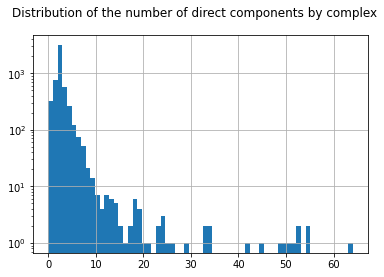

In [14]:
df['nbComponents'].hist(bins=df['nbComponents'].max()+1, log=True)
plt.suptitle("Distribution of the number of direct components by complex")

Query 11: Distribution of the number of complexes a complex is a component of<a class="anchor" id="query11"></a>

Text(0.5, 0.98, 'Distribution of the number of complexes a complex is a component of')

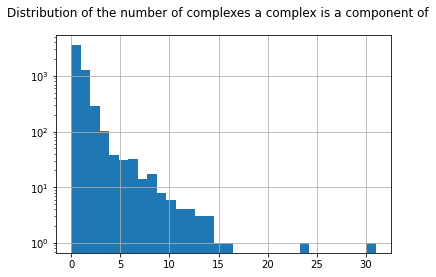

In [15]:
## OD
query="""
# Distribution of the number of complexes a complex is a component of

SELECT ?complex (COUNT(DISTINCT ?whole) AS ?nbWholes)
WHERE {
  {
    ?complex rdf:type bp3:Complex .
    ?whole bp3:component ?complex . 
  }
  UNION
  {
    ?complex rdf:type bp3:Complex .
    FILTER NOT EXISTS {
      ?whole bp3:component ?complex .
    }
  }
}
GROUP BY ?complex
#ORDER BY DESC(?nbComponents)
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df["nbWholes"] = pandas.to_numeric(df["nbWholes"])
df["nbWholes"].describe()
df["nbWholes"].hist(bins=df['nbWholes'].max()+1, log=True)
plt.suptitle("Distribution of the number of complexes a complex is a component of")

Query 12: How many interactions **directly** involve invalid complexes? <a class="anchor" id="query12"></a>

In [16]:
## CJ
query="""
#5734 invalid complexes, composed of 7119 molecules (proteins, smallmolecules et physicalentites)
SELECT (COUNT(DISTINCT ?interaction) AS ?nbInteractions)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent . 
  ?invalidComplexComponent rdf:type bp3:Complex .
  ?invalidComplexComponent bp3:component ?componentOfInvalidComplexComponent .
  
  ?rel rdfs:subPropertyOf* bp3:participant . 
  ?interaction ?rel ?complex .
  
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInteractions
0,7575


Query 13: How many different components (proteins, small molecules et physical entites) are involved in the invalid complexes? <a class="anchor" id="query13"></a>

In [17]:
## CJ
query="""
#5734 invalid complexes, composed of 7119 molecules (proteins, smallmolecules et physicalentites)
SELECT (COUNT(DISTINCT ?leafComponent) AS ?nbInvalidComplexesComponents)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent . 
  ?invalidComplexComponent rdf:type bp3:Complex .
  ?invalidComplexComponent bp3:component ?someComplexComponentComponent .
  
  ?invalidComplex bp3:component+ ?leafComponent .
  
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Complex .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Rna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Dna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Degradation .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:BiochemicalReaction .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:TemplateReaction .}
  
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInvalidComplexesComponents
0,3410


The 5,734 invalid complexes are (in)directly composed of 7,119 distinct entities that are not complexes, interactions, DNA or RNA. Nb: this excludes black-box complexes.

Query 14: How many interactions **directly** involve these components? <a class="anchor" id="query14"></a>

In [18]:
## CJ OD
query="""
#5734 invalid complexes, composed of 7119 molecules (proteins, smallmolecules et physicalentites)
#All interactions that have a participant that is a component of an invalid complex 

SELECT (COUNT(DISTINCT ?interact) AS ?nbInteractions)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent .
  ?invalidComplexComponent bp3:component ?componentOfInvalidComplexComponent .
  
  ?invalidComplex bp3:component* ?leafComponent .

  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Complex .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Rna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Dna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Degradation .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:BiochemicalReaction .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:TemplateReaction .} 
  
  ?interact ?hasParticipant ?leafComponent .
  ?hasParticipant rdfs:subPropertyOf* bp3:participant .
}"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInteractions
0,2506


Query 15: How many interactions involve a complex having a **direct** component that is a component of an invalid complex?  <a class="anchor" id="query15"></a>

Interactions involving a complex composed directly of a component of an invalid complex

In [19]:
query="""
# All interactions that have a participant that is a complex having a direct component that is a component of an invalid complex (excludes black-box complexes)

SELECT (COUNT(DISTINCT ?interact) AS ?nbInteractions)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent .
  ?invalidComplexComponent bp3:component ?componentOfInvalidComplexComponent .
  
  ?invalidComplex bp3:component* ?leafComponent .

  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Complex .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Rna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Dna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Degradation .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:BiochemicalReaction .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:TemplateReaction .}
  
  ?interactParticipant bp3:component? ?leafComponent . # 0 or 1 path
  ?interact ?hasParticipant ?interactParticipant .
  ?hasParticipant rdfs:subPropertyOf* bp3:participant .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInteractions
0,3855


Query 16: How many interactions **directly** and **indirectly** involve these components? <a class="anchor" id="query16"></a>

Interactions involving a complex (valid or invalid) composed indirectly of a component of an invalid complex or the component itself

In [20]:
## CJ OD
query="""
#5734 invalid complexes, composed of 7119 molecules (proteins, smallmolecules et physicalentites)
#Interactions involving a complex composed indirectly of a component of an invalid complex

SELECT (COUNT(DISTINCT ?interact) AS ?nbInteractions)
WHERE {
  ?invalidComplex rdf:type bp3:Complex .
  ?invalidComplex bp3:component ?invalidComplexComponent .
  ?invalidComplexComponent bp3:component ?componentOfInvalidComplexComponent .
  
  ?invalidComplex bp3:component* ?leafComponent .
  
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Complex .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Rna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Dna .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:Degradation .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:BiochemicalReaction .}
  FILTER NOT EXISTS {  ?leafComponent rdf:type bp3:TemplateReaction .}
  
  
  ?interactParticipant bp3:component* ?leafComponent . # 0 or more paths
  ?hasParticipant rdfs:subPropertyOf* bp3:participant .  
  ?interact ?hasParticipant ?interactParticipant .
}
"""

df = sparqldataframe.query(endpointURL, prefixes+query)
df

,nbInteractions
0,4103


### Identify the redundant complexes <a class="anchor" id="identify_redundant"></a>

Query 17: How many pairs of complexes have different identifiers but the same components with the same stoichiometric coefficients and the same cellular location? <a class="anchor" id="query17"></a>

In [21]:
## OD CJ
query = """
# Retrieve redundant complexes i.e. pairs of complexes having different identifiers but the same components with the same stoichiometric coefficients
SELECT DISTINCT ?complex1  ?complex2 # ?id1 ?id2 #?comp ?stoichioValue1 ?stoichioValue2

WHERE {
  #VALUES ?complex { reactome:Complex3 reactome:Complex7 reactome:Complex4 reactome:Complex5 reactome:Complex6 reactome:Complex8 reactome:Complex101 reactome:Complex102 }
  #VALUES ?complex { reactome:Complex102 }
  
  ?complex1 rdf:type bp3:Complex .
  # ?complex1 and ?complex2 have at least 1 common component (to avoid matching all the pairs of blackbox complexes that do not have any components)
  ?complex1 bp3:component ?commonComp .
  ?complex2 bp3:component ?commonComp .
  ?complex2 rdf:type bp3:Complex .
  ?complex1 bp3:cellularLocation ?loc1 .
  ?complex2 bp3:cellularLocation ?loc1 .
  FILTER (str(?complex1) < str(?complex2))
  # ?complex1 and ?complex2 do not have any common component that has different stoichiometric coefficients between the two complexes
  FILTER NOT EXISTS {
    ?complex1 bp3:component ?comp .
    ?complex2 bp3:component ?comp .
    #?complex1 bp3:cellularLocation ?loc1 .
    ?complex1 bp3:componentStoichiometry ?stoichio1 .
    ?stoichio1 bp3:physicalEntity ?comp .
    ?stoichio1 bp3:stoichiometricCoefficient ?stoichioValue1 .

    ?complex2 bp3:componentStoichiometry ?stoichio2 .
    ?stoichio2 bp3:physicalEntity ?comp .
    #?complex2 bp3:cellularLocation ?loc2 .
    ?stoichio2 bp3:stoichiometricCoefficient ?stoichioValue2 .
    FILTER (?stoichioValue1 != ?stoichioValue2)
    #FILTER (?loc1 != ?loc2)
  }


  # all the direct components of ?complex1 are also components of ?complex2
  FILTER NOT EXISTS {
    ?complex1 bp3:component ?comp1 .
    FILTER NOT EXISTS {
      ?complex2 bp3:component ?comp1 .
    }
  }
  # all the direct components of ?complex2 are also components of ?complex1
  FILTER NOT EXISTS {
    ?complex2 bp3:component ?comp2 .
    FILTER NOT EXISTS {
      ?complex1 bp3:component ?comp2 .
    }
  }
 OPTIONAL{ ?complex1 bp3:xref ?xref1 .
    ?xref1 bp3:db "ComplexPortal" .
    ?xref1 bp3:id ?id1 . }
  
OPTIONAL{ ?complex2 bp3:xref ?xref2 .
    ?xref2 bp3:db "ComplexPortal" .
    ?xref2 bp3:id ?id2 . }
}
"""
df = sparqldataframe.query(endpointURL, prefixes+query)
df

,complex1,complex2
0,http://www.reactome.org/biopax/81/56210#Complex3540,http://www.reactome.org/biopax/81/56210#Complex3761
1,http://www.reactome.org/biopax/81/56210#Complex3594,http://www.reactome.org/biopax/81/56210#Complex3596


How many cliques? <a class="anchor" id="cliques"></a>

In [22]:
cliques = {df["complex1"][0] : [df["complex2"][0]]}
for row in df.itertuples(index=False):
    if row[0] in cliques :
        cliques[row[0]].append(row[1])
    elif row[1] in cliques :
        cliques[row[1]].append(row[0])
    else :
        found = False
        for i in cliques :
            if row[0] in cliques[i]:
                cliques[i].append(row[1])
                found = True
                break
            elif row[1] in cliques[i]:
                cliques[i].append(row[0])
                found = True
                break
        if not found :
            cliques[row[0]] = list()
            cliques[row[0]].append(row[1])
       
len(cliques) 

2

* * *
### Fix the invalid complexes <a class="anchor" id="fix_complexes"></a>

- step 0: retrieve Reactome
       wget https://reactome.org/download/current/biopax.zip
       unzip biopax.zip Homo_sapiens.owl
       echo "Reactome version: $(expr "$(grep xml:base Homo_sapiens.owl)" : '.*http:\/\/www.reactome.org\/biopax\/\([[:digit:]]*\).*')"

- step 1: setup SPARQL endpoint with reactome
       # broken with fuseki-4.4.0: 
       # temporary fix
       ${FUSEKI_HOME}/fuseki-server --mem --update /reactome
       # then manually load Homo_sapiens.owl

- step 2: export the valid complexes

- step 3: export the fixed invalid complexes

- step 4: export reactome without complexes

![]("./Figure_drawio/2022_03_17_Stoichio.pdf")

Function 1: fix invalid complexes <a class="anchor" id="function1"></a>

In [23]:
def fixInvalidComplexes():
    ##### FIX INVALID COMPLEXES
    queryPath = 'queries/template-fixInvalidComplexes.rq'
    sparqlQuery = pathlib.Path(queryPath).read_text().replace('$supplementaryPrefixes$',uri_utils.convertPrefixesDictToSPARQL(prefixesDict)) 
#     sparql = SPARQLWrapper(endpointURL)
    sparql.setQuery(sparqlQuery)
    sparql.setReturnFormat(JSON)
    results = sparql.query().convert()
    nbInvalidComplexes = len(results["results"]["bindings"])
    i = 0
    for result in results["results"]["bindings"]:
        print("{}\t{}\t{}".format(i, time.time()-startTime, result['invalidComplex']['value']))
        validGraph = rdflib.Graph()
        validGraph.bind("bp3","http://www.biopax.org/release/biopax-level3.owl#")
        complexComponents.getRepresentationBiopaxValid(endpointURL, result['invalidComplex']['value'], prefixesDict=prefixesDict, targetGraph=validGraph, rdfFormat="turtle", biopaxFilePath="")
        with open(path_results + "/reactome-v" + str(reactomeVersion) + '-' + str(species) + "-" + result['invalidComplex']['value'].replace("http://www.reactome.org/biopax/" + str(reactomeVersion) + "/" + str(species) + "#", "") + "-valid.ttl", 'w') as rdfFile:
            rdfFile.write(validGraph.serialize(format=rdfFormat).encode().decode('UTF-8'))
        i += 1
    
    # ${JENA_HOME}/bin/riot --time --output=Turtle result/reactome-v79-Complex*.ttl > reactome-v79-complexes-invalid-fixed.ttl

Function 2: export valid complexes <a class="anchor" id="function2"></a>

In [41]:
def exportValidComplexes():
    ##### EXPORT VALID PART OF REACTOME
    queryPath = 'queries/template-extractValidComplexes-construct.rq'
    sparqlQuery = pathlib.Path(queryPath).read_text().replace('$supplementaryPrefixes$',uri_utils.convertPrefixesDictToSPARQL(prefixesDict)) 
    sparql.setQuery(sparqlQuery)
    sparql.setReturnFormat(rdfFormat)
    results = sparql.query().convert()
    validGraph = rdflib.Graph()
    validGraph.parse(data=results, format=rdfFormat)

    with open(path_results + "/reactome-v" + str(reactomeVersion) + '-' + str(species) + "-complexes-valid.ttl", 'w', encoding="utf-8") as rdfFile:
        rdfFile.write(validGraph.serialize(format=rdfFormat).encode('UTF-8').decode('UTF-8'))

Function 3: delete all complexes  <a class="anchor" id="function3"></a>

In [25]:
def deleteAllComplexes():
    queryPath = 'queries/deleteOriginalComplexes.rq'
    sparqlQuery = pathlib.Path(queryPath).read_text().replace('$supplementaryPrefixes$',uri_utils.convertPrefixesDictToSPARQL(prefixesDict))
    print("Calling: " + endpointURL.replace("query", "update"))
    sparql = SPARQLWrapper(endpointURL.replace("query", "update"))
    sparql.setQuery(sparqlQuery)
    sparql.method = 'POST'
    #sparql.setReturnFormat(JSON)
    sparql.query()

In [26]:
validGraph = rdflib.Graph()
sparql = SPARQLWrapper(endpointURL)

In [29]:
startTime = time.time()
fixInvalidComplexes()
endTime = time.time()
print("Duration: {}".format(endTime - startTime))

0	0.13292336463928223	http://www.reactome.org/biopax/81/56210#Complex2
1	0.3771071434020996	http://www.reactome.org/biopax/81/56210#Complex3
2	0.5089759826660156	http://www.reactome.org/biopax/81/56210#Complex5
3	0.754070520401001	http://www.reactome.org/biopax/81/56210#Complex8
4	1.0619983673095703	http://www.reactome.org/biopax/81/56210#Complex6
5	1.2348146438598633	http://www.reactome.org/biopax/81/56210#Complex10
6	1.8392410278320312	http://www.reactome.org/biopax/81/56210#Complex11
7	3.573866128921509	http://www.reactome.org/biopax/81/56210#Complex17
8	5.0905702114105225	http://www.reactome.org/biopax/81/56210#Complex12
9	5.3785622119903564	http://www.reactome.org/biopax/81/56210#Complex15
10	5.738021612167358	http://www.reactome.org/biopax/81/56210#Complex48
11	5.875564336776733	http://www.reactome.org/biopax/81/56210#Complex73
12	6.002430200576782	http://www.reactome.org/biopax/81/56210#Complex76
13	6.149769067764282	http://www.reactome.org/biopax/81/56210#Complex78
14	6.6931838

116	47.1140878200531	http://www.reactome.org/biopax/81/56210#Complex335
117	47.72438907623291	http://www.reactome.org/biopax/81/56210#Complex338
118	49.31884741783142	http://www.reactome.org/biopax/81/56210#Complex339
119	52.972397804260254	http://www.reactome.org/biopax/81/56210#Complex340
120	56.525938272476196	http://www.reactome.org/biopax/81/56210#Complex342
121	60.001744508743286	http://www.reactome.org/biopax/81/56210#Complex343
122	61.457420349121094	http://www.reactome.org/biopax/81/56210#Complex344
123	62.52199649810791	http://www.reactome.org/biopax/81/56210#Complex345
124	63.45829105377197	http://www.reactome.org/biopax/81/56210#Complex346
125	64.10310435295105	http://www.reactome.org/biopax/81/56210#Complex348
126	67.92318868637085	http://www.reactome.org/biopax/81/56210#Complex349
127	71.54610681533813	http://www.reactome.org/biopax/81/56210#Complex350
128	75.21583986282349	http://www.reactome.org/biopax/81/56210#Complex351
129	77.88670992851257	http://www.reactome.org/bi

228	205.97264885902405	http://www.reactome.org/biopax/81/56210#Complex562
229	206.77179789543152	http://www.reactome.org/biopax/81/56210#Complex561
230	207.33909964561462	http://www.reactome.org/biopax/81/56210#Complex563
231	207.91113543510437	http://www.reactome.org/biopax/81/56210#Complex564
232	208.548344373703	http://www.reactome.org/biopax/81/56210#Complex565
233	209.05074048042297	http://www.reactome.org/biopax/81/56210#Complex566
234	209.57054996490479	http://www.reactome.org/biopax/81/56210#Complex568
235	210.3780541419983	http://www.reactome.org/biopax/81/56210#Complex569
236	211.21404385566711	http://www.reactome.org/biopax/81/56210#Complex570
237	211.71739387512207	http://www.reactome.org/biopax/81/56210#Complex571
238	212.31243252754211	http://www.reactome.org/biopax/81/56210#Complex572
239	212.91163063049316	http://www.reactome.org/biopax/81/56210#Complex573
240	213.5767149925232	http://www.reactome.org/biopax/81/56210#Complex576
241	214.20753264427185	http://www.reactome

341	302.2286128997803	http://www.reactome.org/biopax/81/56210#Complex757
342	303.4277820587158	http://www.reactome.org/biopax/81/56210#Complex745
343	304.4892780780792	http://www.reactome.org/biopax/81/56210#Complex747
344	305.26678109169006	http://www.reactome.org/biopax/81/56210#Complex748
345	305.9914357662201	http://www.reactome.org/biopax/81/56210#Complex749
346	306.3913748264313	http://www.reactome.org/biopax/81/56210#Complex752
347	306.63023948669434	http://www.reactome.org/biopax/81/56210#Complex750
348	306.9210059642792	http://www.reactome.org/biopax/81/56210#Complex754
349	307.0691134929657	http://www.reactome.org/biopax/81/56210#Complex758
350	308.2645173072815	http://www.reactome.org/biopax/81/56210#Complex762
351	309.2957890033722	http://www.reactome.org/biopax/81/56210#Complex766
352	309.6005947589874	http://www.reactome.org/biopax/81/56210#Complex767
353	309.74314284324646	http://www.reactome.org/biopax/81/56210#Complex768
354	309.88489389419556	http://www.reactome.org/b

453	351.2052812576294	http://www.reactome.org/biopax/81/56210#Complex994
454	351.40699434280396	http://www.reactome.org/biopax/81/56210#Complex995
455	351.49285316467285	http://www.reactome.org/biopax/81/56210#Complex996
456	351.6095678806305	http://www.reactome.org/biopax/81/56210#Complex999
457	351.69901752471924	http://www.reactome.org/biopax/81/56210#Complex1000
458	351.78897500038147	http://www.reactome.org/biopax/81/56210#Complex1001
459	351.9260251522064	http://www.reactome.org/biopax/81/56210#Complex1004
460	352.0638391971588	http://www.reactome.org/biopax/81/56210#Complex1002
461	352.1658778190613	http://www.reactome.org/biopax/81/56210#Complex1005
462	352.28777503967285	http://www.reactome.org/biopax/81/56210#Complex1008
463	352.3762936592102	http://www.reactome.org/biopax/81/56210#Complex1013
464	352.46658635139465	http://www.reactome.org/biopax/81/56210#Complex1015
465	352.5572967529297	http://www.reactome.org/biopax/81/56210#Complex1017
466	352.65074467658997	http://www.re

565	372.636027097702	http://www.reactome.org/biopax/81/56210#Complex1269
566	372.7715582847595	http://www.reactome.org/biopax/81/56210#Complex1274
567	372.8749098777771	http://www.reactome.org/biopax/81/56210#Complex1275
568	373.72673535346985	http://www.reactome.org/biopax/81/56210#Complex1276
569	374.01202297210693	http://www.reactome.org/biopax/81/56210#Complex1280
570	374.38908791542053	http://www.reactome.org/biopax/81/56210#Complex1285
571	374.49297165870667	http://www.reactome.org/biopax/81/56210#Complex1287
572	374.63887071609497	http://www.reactome.org/biopax/81/56210#Complex1291
573	374.777649641037	http://www.reactome.org/biopax/81/56210#Complex1294
574	374.8509111404419	http://www.reactome.org/biopax/81/56210#Complex1292
575	374.9514129161835	http://www.reactome.org/biopax/81/56210#Complex1296
576	375.1524600982666	http://www.reactome.org/biopax/81/56210#Complex1297
577	375.27921199798584	http://www.reactome.org/biopax/81/56210#Complex1301
578	375.4564960002899	http://www.r

678	547.864443063736	http://www.reactome.org/biopax/81/56210#Complex1625
679	550.9159746170044	http://www.reactome.org/biopax/81/56210#Complex1626
680	551.4786086082458	http://www.reactome.org/biopax/81/56210#Complex1627
681	551.6326034069061	http://www.reactome.org/biopax/81/56210#Complex1629
682	551.831517457962	http://www.reactome.org/biopax/81/56210#Complex1640
683	552.1353759765625	http://www.reactome.org/biopax/81/56210#Complex1642
684	552.4671506881714	http://www.reactome.org/biopax/81/56210#Complex1645
685	552.5673463344574	http://www.reactome.org/biopax/81/56210#Complex1647
686	552.6640617847443	http://www.reactome.org/biopax/81/56210#Complex1651
687	555.7188286781311	http://www.reactome.org/biopax/81/56210#Complex1656
688	555.8707277774811	http://www.reactome.org/biopax/81/56210#Complex1662
689	556.0140528678894	http://www.reactome.org/biopax/81/56210#Complex1664
690	556.1527900695801	http://www.reactome.org/biopax/81/56210#Complex1667
691	556.2792241573334	http://www.reactom

790	587.3218052387238	http://www.reactome.org/biopax/81/56210#Complex1896
791	587.4418287277222	http://www.reactome.org/biopax/81/56210#Complex1897
792	587.5766229629517	http://www.reactome.org/biopax/81/56210#Complex1898
793	587.692355632782	http://www.reactome.org/biopax/81/56210#Complex1899
794	587.8011431694031	http://www.reactome.org/biopax/81/56210#Complex1903
795	587.9088044166565	http://www.reactome.org/biopax/81/56210#Complex1905
796	588.0134515762329	http://www.reactome.org/biopax/81/56210#Complex1906
797	588.2095093727112	http://www.reactome.org/biopax/81/56210#Complex1908
798	588.4879472255707	http://www.reactome.org/biopax/81/56210#Complex1912
799	588.6066133975983	http://www.reactome.org/biopax/81/56210#Complex1929
800	588.7051386833191	http://www.reactome.org/biopax/81/56210#Complex1934
801	588.865119934082	http://www.reactome.org/biopax/81/56210#Complex1936
802	589.0792307853699	http://www.reactome.org/biopax/81/56210#Complex1937
803	589.1969568729401	http://www.reactom

902	606.7045900821686	http://www.reactome.org/biopax/81/56210#Complex2171
903	606.8128654956818	http://www.reactome.org/biopax/81/56210#Complex2172
904	606.9159450531006	http://www.reactome.org/biopax/81/56210#Complex2174
905	607.0186524391174	http://www.reactome.org/biopax/81/56210#Complex2175
906	607.5461716651917	http://www.reactome.org/biopax/81/56210#Complex2178
907	608.1079425811768	http://www.reactome.org/biopax/81/56210#Complex2176
908	608.2669544219971	http://www.reactome.org/biopax/81/56210#Complex2206
909	608.3443105220795	http://www.reactome.org/biopax/81/56210#Complex2207
910	608.4288241863251	http://www.reactome.org/biopax/81/56210#Complex2209
911	608.4990613460541	http://www.reactome.org/biopax/81/56210#Complex2210
912	608.5700702667236	http://www.reactome.org/biopax/81/56210#Complex2212
913	608.6711447238922	http://www.reactome.org/biopax/81/56210#Complex2213
914	608.7808151245117	http://www.reactome.org/biopax/81/56210#Complex2215
915	608.8989641666412	http://www.react

1014	625.569988489151	http://www.reactome.org/biopax/81/56210#Complex2500
1015	625.6817212104797	http://www.reactome.org/biopax/81/56210#Complex2502
1016	625.7956988811493	http://www.reactome.org/biopax/81/56210#Complex2505
1017	625.9067294597626	http://www.reactome.org/biopax/81/56210#Complex2506
1018	626.0235698223114	http://www.reactome.org/biopax/81/56210#Complex2508
1019	626.2277460098267	http://www.reactome.org/biopax/81/56210#Complex2512
1020	626.4148349761963	http://www.reactome.org/biopax/81/56210#Complex2510
1021	626.5680990219116	http://www.reactome.org/biopax/81/56210#Complex2513
1022	626.7131180763245	http://www.reactome.org/biopax/81/56210#Complex2515
1023	626.8187260627747	http://www.reactome.org/biopax/81/56210#Complex2516
1024	626.9188272953033	http://www.reactome.org/biopax/81/56210#Complex2517
1025	627.0292029380798	http://www.reactome.org/biopax/81/56210#Complex2520
1026	627.1556529998779	http://www.reactome.org/biopax/81/56210#Complex2522
1027	627.2813098430634	htt

1125	645.4445757865906	http://www.reactome.org/biopax/81/56210#Complex2780
1126	645.6846790313721	http://www.reactome.org/biopax/81/56210#Complex2783
1127	645.9316701889038	http://www.reactome.org/biopax/81/56210#Complex2781
1128	646.0098440647125	http://www.reactome.org/biopax/81/56210#Complex2784
1129	646.2461597919464	http://www.reactome.org/biopax/81/56210#Complex2785
1130	646.5146405696869	http://www.reactome.org/biopax/81/56210#Complex2786
1131	646.7240183353424	http://www.reactome.org/biopax/81/56210#Complex2787
1132	646.9619510173798	http://www.reactome.org/biopax/81/56210#Complex2794
1133	647.0673105716705	http://www.reactome.org/biopax/81/56210#Complex2797
1134	647.7728021144867	http://www.reactome.org/biopax/81/56210#Complex2798
1135	647.9238822460175	http://www.reactome.org/biopax/81/56210#Complex2800
1136	648.860860824585	http://www.reactome.org/biopax/81/56210#Complex2801
1137	649.7072062492371	http://www.reactome.org/biopax/81/56210#Complex2803
1138	649.9547383785248	htt

1235	666.0766890048981	http://www.reactome.org/biopax/81/56210#Complex3027
1236	666.2411184310913	http://www.reactome.org/biopax/81/56210#Complex3029
1237	666.3333241939545	http://www.reactome.org/biopax/81/56210#Complex3030
1238	666.4261190891266	http://www.reactome.org/biopax/81/56210#Complex3031
1239	666.5426337718964	http://www.reactome.org/biopax/81/56210#Complex3033
1240	666.6645011901855	http://www.reactome.org/biopax/81/56210#Complex3034
1241	666.73295378685	http://www.reactome.org/biopax/81/56210#Complex3036
1242	666.8627207279205	http://www.reactome.org/biopax/81/56210#Complex3037
1243	666.932276725769	http://www.reactome.org/biopax/81/56210#Complex3038
1244	667.0361437797546	http://www.reactome.org/biopax/81/56210#Complex3039
1245	667.1417820453644	http://www.reactome.org/biopax/81/56210#Complex3041
1246	667.2373158931732	http://www.reactome.org/biopax/81/56210#Complex3042
1247	667.3428437709808	http://www.reactome.org/biopax/81/56210#Complex3043
1248	667.4753074645996	http:

1346	691.3579230308533	http://www.reactome.org/biopax/81/56210#Complex3262
1347	691.5623939037323	http://www.reactome.org/biopax/81/56210#Complex3263
1348	692.223217010498	http://www.reactome.org/biopax/81/56210#Complex3267
1349	692.7050430774689	http://www.reactome.org/biopax/81/56210#Complex3272
1350	693.2732093334198	http://www.reactome.org/biopax/81/56210#Complex3284
1351	693.5915882587433	http://www.reactome.org/biopax/81/56210#Complex3286
1352	693.803261756897	http://www.reactome.org/biopax/81/56210#Complex3287
1353	694.3203430175781	http://www.reactome.org/biopax/81/56210#Complex3288
1354	694.7155213356018	http://www.reactome.org/biopax/81/56210#Complex3290
1355	695.2332360744476	http://www.reactome.org/biopax/81/56210#Complex3291
1356	695.8070080280304	http://www.reactome.org/biopax/81/56210#Complex3297
1357	696.7983379364014	http://www.reactome.org/biopax/81/56210#Complex3298
1358	697.293178319931	http://www.reactome.org/biopax/81/56210#Complex3300
1359	697.5521922111511	http:

1456	731.3410220146179	http://www.reactome.org/biopax/81/56210#Complex3702
1457	731.4296071529388	http://www.reactome.org/biopax/81/56210#Complex3703
1458	731.5119137763977	http://www.reactome.org/biopax/81/56210#Complex3704
1459	731.6133944988251	http://www.reactome.org/biopax/81/56210#Complex3705
1460	731.7110550403595	http://www.reactome.org/biopax/81/56210#Complex3706
1461	731.8068356513977	http://www.reactome.org/biopax/81/56210#Complex3715
1462	731.8966164588928	http://www.reactome.org/biopax/81/56210#Complex3716
1463	732.2135171890259	http://www.reactome.org/biopax/81/56210#Complex3718
1464	732.290388584137	http://www.reactome.org/biopax/81/56210#Complex3721
1465	732.3690328598022	http://www.reactome.org/biopax/81/56210#Complex3722
1466	732.4543228149414	http://www.reactome.org/biopax/81/56210#Complex3724
1467	732.6156582832336	http://www.reactome.org/biopax/81/56210#Complex3725
1468	732.8255999088287	http://www.reactome.org/biopax/81/56210#Complex3727
1469	733.026752948761	http

1566	897.5950076580048	http://www.reactome.org/biopax/81/56210#Complex4036
1567	899.7375159263611	http://www.reactome.org/biopax/81/56210#Complex4037
1568	901.620564699173	http://www.reactome.org/biopax/81/56210#Complex4038
1569	901.9826412200928	http://www.reactome.org/biopax/81/56210#Complex4039
1570	904.681126832962	http://www.reactome.org/biopax/81/56210#Complex4040
1571	907.2546730041504	http://www.reactome.org/biopax/81/56210#Complex4041
1572	907.4960062503815	http://www.reactome.org/biopax/81/56210#Complex4042
1573	907.6105709075928	http://www.reactome.org/biopax/81/56210#Complex4046
1574	908.0081021785736	http://www.reactome.org/biopax/81/56210#Complex4053
1575	908.3611319065094	http://www.reactome.org/biopax/81/56210#Complex4058
1576	908.4446229934692	http://www.reactome.org/biopax/81/56210#Complex4059
1577	908.5360643863678	http://www.reactome.org/biopax/81/56210#Complex4063
1578	908.6336486339569	http://www.reactome.org/biopax/81/56210#Complex4065
1579	908.9354898929596	http

1676	997.487140417099	http://www.reactome.org/biopax/81/56210#Complex4533
1677	997.5832557678223	http://www.reactome.org/biopax/81/56210#Complex4534
1678	997.8698523044586	http://www.reactome.org/biopax/81/56210#Complex4535
1679	998.2883155345917	http://www.reactome.org/biopax/81/56210#Complex4536
1680	999.3669655323029	http://www.reactome.org/biopax/81/56210#Complex4538
1681	1001.2773897647858	http://www.reactome.org/biopax/81/56210#Complex4539
1682	1003.5146977901459	http://www.reactome.org/biopax/81/56210#Complex4540
1683	1003.8280649185181	http://www.reactome.org/biopax/81/56210#Complex4544
1684	1006.9551522731781	http://www.reactome.org/biopax/81/56210#Complex4545
1685	1010.1405334472656	http://www.reactome.org/biopax/81/56210#Complex4546
1686	1014.7446415424347	http://www.reactome.org/biopax/81/56210#Complex4548
1687	1017.9406328201294	http://www.reactome.org/biopax/81/56210#Complex4547
1688	1018.3041825294495	http://www.reactome.org/biopax/81/56210#Complex4549
1689	1020.61424756

1785	1044.7300653457642	http://www.reactome.org/biopax/81/56210#Complex4944
1786	1044.9173877239227	http://www.reactome.org/biopax/81/56210#Complex4946
1787	1045.170393705368	http://www.reactome.org/biopax/81/56210#Complex4947
1788	1045.3692951202393	http://www.reactome.org/biopax/81/56210#Complex4948
1789	1045.551542043686	http://www.reactome.org/biopax/81/56210#Complex4950
1790	1045.760187625885	http://www.reactome.org/biopax/81/56210#Complex4959
1791	1045.855438709259	http://www.reactome.org/biopax/81/56210#Complex4962
1792	1045.9605810642242	http://www.reactome.org/biopax/81/56210#Complex4963
1793	1046.0955905914307	http://www.reactome.org/biopax/81/56210#Complex4966
1794	1046.1908447742462	http://www.reactome.org/biopax/81/56210#Complex4968
1795	1046.283756494522	http://www.reactome.org/biopax/81/56210#Complex4973
1796	1046.3803958892822	http://www.reactome.org/biopax/81/56210#Complex4974
1797	1046.5051124095917	http://www.reactome.org/biopax/81/56210#Complex4976
1798	1046.6082019

1895	1067.2259271144867	http://www.reactome.org/biopax/81/56210#Complex5220
1896	1067.4604976177216	http://www.reactome.org/biopax/81/56210#Complex5221
1897	1067.6173176765442	http://www.reactome.org/biopax/81/56210#Complex5222
1898	1067.7814409732819	http://www.reactome.org/biopax/81/56210#Complex5224
1899	1067.9764807224274	http://www.reactome.org/biopax/81/56210#Complex5225
1900	1068.2061262130737	http://www.reactome.org/biopax/81/56210#Complex5227
1901	1068.4771196842194	http://www.reactome.org/biopax/81/56210#Complex5230
1902	1068.789883852005	http://www.reactome.org/biopax/81/56210#Complex5232
1903	1069.0679726600647	http://www.reactome.org/biopax/81/56210#Complex5233
1904	1069.3140096664429	http://www.reactome.org/biopax/81/56210#Complex5235
1905	1069.661389350891	http://www.reactome.org/biopax/81/56210#Complex5237
1906	1069.8972129821777	http://www.reactome.org/biopax/81/56210#Complex5240
1907	1070.1075534820557	http://www.reactome.org/biopax/81/56210#Complex5242
1908	1070.2995

In [30]:
# concat files
#%%bash
#${JENA_HOME}/bat/riot --time --output=Turtle result/reactome-v79-Complex*.ttl > reactome-v79-complexes-invalid-fixed.ttl

In [42]:
startTime = time.time()
exportValidComplexes()
endTime = time.time()
print("Duration: {}".format(endTime - startTime))

Duration: 185.76708149909973


In [43]:
startTime = time.time()
deleteAllComplexes()
endTime = time.time()
print("Duration: {}".format(endTime - startTime))

Calling: http://localhost:3030/REACTOME_DROSOPHILIA/update
Duration: 285.8789801597595
